# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 6: *HoughTransformLineDecomposition*
Line detection by the Hough transform decomposition
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Module functions
from ImageUtilities import imageReadL, plotImageF, plotImageL, createScaleImageL, createVectorF
from ImageOperatorsUtilities import applyCannyEdgeDetector
from ImagePropertiesUtilities import imageMaxMin, peakDetectorVector
from PlotUtilities import plot3DHistogram, plotHistogram

# Math and iteration
from math import fabs, sqrt, pi, sin, cos, atan2, atan
from timeit import itertools

### Parameters:
    pathToDir = Input image directory
    imageName = Input image name
    gaussianKernelSize = Gaussian kernel size. Filter noise
    sobelKernelSize = Sobel kernel size. Edge detection
    upperT = Upper threshold
    lowerT = Lower threshold
    peakDetection = Percentage of the maximum peak value that is considered for threshold
    deltaPtRange = How far is the second point

In [2]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter6/Input/")
imageName = "Road.png"
gaussianKernelSize = 7
sobelKernelSize = 3
upperT = 0.5
lowerT = 0.3
peakDetection = 0.6
peakDetectionR = 0.7
deltaPtRange = [10, 15]

### Read and show input image

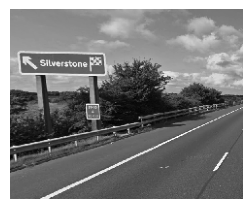

In [3]:
inputImage, width, height  = imageReadL(pathToDir + imageName)
plotImageL(inputImage, figureSize = 3)

### Compute edges

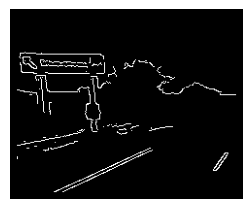

In [4]:
magnitude, angle = applyCannyEdgeDetector(inputImage, gaussianKernelSize, sobelKernelSize, upperT, lowerT)
plotImageF(magnitude, figureSize = 3)

### Gather evidence for a point x,y

In [5]:
# Accumulator for the slope in degrees
maxLenght = int(sqrt(height*height + width*width) / 2)
accM = createVectorF(360) 
cx, cy = int(width/2), int(height/2)
    
# Gather evidence for a point x,y
for x,y in itertools.product(range(0, width), range(0, height)):
    if magnitude[y,x] != 0:
        # Look for points at this distance
        for dx,dy in itertools.product(range(-deltaPtRange[1],deltaPtRange[1]+1),    \
                                       range(-deltaPtRange[1],deltaPtRange[1]+1)):
        
            if abs(dx) > deltaPtRange[0] or abs(dy) > deltaPtRange[0]:
                wx,wy = x+dx, y+dy
                if wx > 0 and wy > 0 and wx < width and wy < height                         \
                          and magnitude[wy, wx] !=0:
                    pointAngle = atan2(-float(wx-x), float(wy-y)) + pi
      
                    # If r is negative, the line is in the other side of the centre
                    r = (x-cx) * cos(pointAngle) + (y-cy) * sin(pointAngle)
                    if r < 0:
                        if pointAngle > pi: pointAngle -= pi
                        else:               pointAngle += pi
                    
                    # Accumulator entries depend on the distance to the second point
                    deltaDistance = sqrt(dx*dx + dy*dy)
                    incAngle = int(atan(1.0/deltaDistance) * 180.0 / pi)
                 
                    buketAngleBase = int((pointAngle * 180.0) / pi)   
                 
                    # More buckets if the points are close
                    for deltaBucket in range(-incAngle, +incAngle+1):
                        bucket = buketAngleBase + deltaBucket 
                        if bucket < 0:
                            bucket = 360 + bucket
                        if bucket >= 360:
                            bucket = bucket-360
                            
                        w = (incAngle - fabs(deltaBucket)) / float(incAngle)
                        accM[bucket] += w

### Find maximum and plot histogram

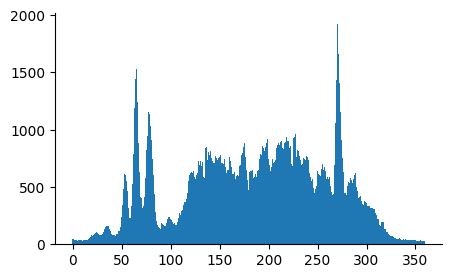

In [6]:
maximum, _ = imageMaxMin(accM)
peakThreshold = peakDetection * maximum
plotHistogram(accM)

### Gather evidence for the r parameter in a second accumulator

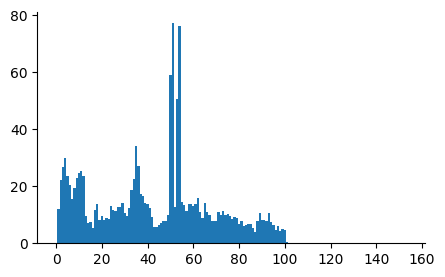

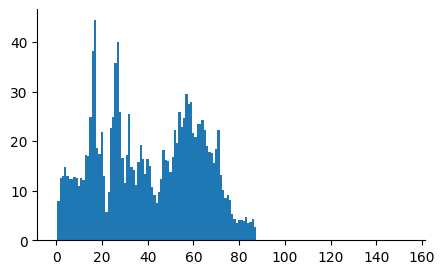

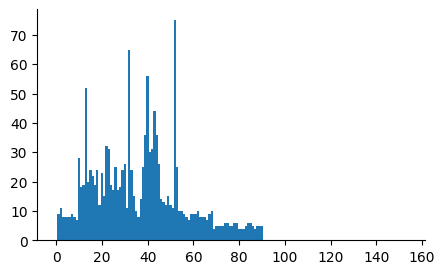

In [7]:
# Prepare output image as a dark version of the input
outputImage = createScaleImageL(inputImage, 0.5)


peaks = peakDetectorVector(accM, peakThreshold)
for peakIndex in range(0,len(peaks)):
    m = peaks[peakIndex]
    
    accR = createVectorF(maxLenght)
    angle = (m * pi) / 180.0
    for x,y in itertools.product(range(0, width), range(0, height)):
        if magnitude[y,x] != 0:
            r = fabs((x-cx) * cos(angle) + (y-cy) * sin(angle))
            bucket = int(r)
            if bucket> 0 and bucket < maxLenght - 1:
                weight = r - int(r)
                accR[bucket] += (1.0 - weight)
                accR[bucket+1] += weight
    plotHistogram(accR)

    # Find maximum in second accumulator
    maximumR, _ = imageMaxMin(accR)
    peakThresholdR = peakDetectionR * maximumR
    peaksR = peakDetectorVector(accR, peakThresholdR)
    
    # Draw the result
    for peakRIndex in range(0,len(peaksR)):
        r = peaksR[peakRIndex]
        strength = int(255.0 * accR[r] / maximumR)
        angle = (m * pi) / 180.0
        
        if  fabs(cos(angle)) <  fabs(sin(angle)):
            for x in range(0, width -1):
                y = int( (r - (x-cx) * cos(angle) ) / sin(angle)) + cy
                if y > 0 and y < height -1:
                    outputImage[y,x] = strength
                    outputImage[y+1,x] = strength
        else:
            for y in range(0, height -1):
                x = int( (r - (y-cy) * sin(angle) ) / cos(angle)) + cx
                if x > 0 and x < width -1:
                    outputImage[y,x] = strength
                    outputImage[y+1,x] = strength

### Show image with detected lines 

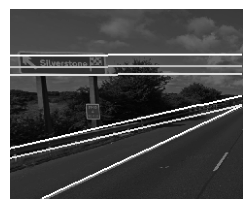

In [8]:
plotImageL(outputImage, figureSize = 3)